In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import *
from prophet import Prophet
from sklearn import preprocessing
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import itertools
from typing import List

In [26]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Load training data

In [13]:
df = pd.read_csv('data/df_final.csv')
df['dates'] = pd.to_datetime(df['dates'])

# map to 1 & 0
mapped = {'AB':1, 'Non-AB':0}
df.brewer = df.brewer.map(mapped)

In [14]:
unique_wholesalers = list(df.wholesaler_id_value.unique())
unique_products = list(df.product_key.unique())

In [15]:
no_sales_list = []

for w in unique_wholesalers:
    for p in unique_products:
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        if df_small.shape[0]<53:
            no_sales_list.append((w, p))

## Load trained Prophet models

In [16]:
import pickle

# Load model dict -- 

with open('model_dict.pickle', 'rb') as handle:
    model_dict = pickle.load(handle)

## Add additional features

In [17]:
import pendulum

def get_holidays(df):
    
    """ 
    Adding holidays column to indicate whether a day was a holiday assuming this data is from US.
    
    """

    cal = calendar()
    holidays_list = []
    for d in cal.holidays().to_list():
        d = d.strftime('%Y-%m-%d')
        day = pendulum.from_format(f'{d}', 'YYYY-MM-DD')
        end = pd.to_datetime(day.end_of('week'))
        holidays_list.append(end.strftime('%Y-%m-%d'))

    df['holiday'] = df['ds'].isin(holidays_list)
    
    # map to 1 & 0
    mapped = {True:1, False:0}
    df.holiday = df.holiday.map(mapped)
    
    return df

In [18]:
def add_features(
w: int,
p: int,
train_df: pd.DataFrame,
future_df: pd.DataFrame
)-> pd.DataFrame():
    
    latest_price = list(df[(df['wholesaler_id_value']==w) & (df['product_key']== p)]['product_price'])[-1]
    latest_relative_beer_style_price = list(df[(df['wholesaler_id_value']==w) & (df['product_key']== p)]['product_price'])[-1]
    latest_brewer = list(df[(df['wholesaler_id_value']==w) & (df['product_key']== p)]['brewer'])[-1]

    future_df['product_price'] = latest_price
    future_df['relative_beer_style_price'] = latest_relative_beer_style_price
    future_df['brewer'] = latest_brewer

    return get_holidays(future_df)
    

## Generate predictions

In [20]:
# predict over the datasets

all_predictions = []

for w in unique_wholesalers:
    for p in unique_products:
        if (w, p) not in no_sales_list:
            
            print(f'Generating predictions for wholesaler {w} & product {p} ---- ')
            
            model = model_dict.get((w,p))
            future_pd = model.make_future_dataframe(
                    periods = 8,
                    freq = 'w',
                    include_history=False
            )  
            
            predictions_fb = model.predict(add_features(w, p, df, future_pd))
            all_predictions.append(predictions_fb[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
            
            print(f'[DONE] Predictions saved for wholesaler {w} & product {p} ---- ')

Generating predictions for wholesaler 3142 & product 210280222 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 210280222 ---- 
Generating predictions for wholesaler 3142 & product 210281267 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 210281267 ---- 
Generating predictions for wholesaler 3142 & product 210283096 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 210283096 ---- 
Generating predictions for wholesaler 3142 & product 210284670 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 210284670 ---- 
Generating predictions for wholesaler 3142 & product 1412422 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 1412422 ---- 
Generating predictions for wholesaler 3142 & product 210281273 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 210281273 ---- 
Generating predictions for wholesaler 3142 & product 659550424 ---- 
[DONE] Predictions saved for wholesaler 3142 & product 659550424 ---- 
Generating predictions f

[DONE] Predictions saved for wholesaler 64221 & product 1412422 ---- 
Generating predictions for wholesaler 64221 & product 210281273 ---- 
[DONE] Predictions saved for wholesaler 64221 & product 210281273 ---- 
Generating predictions for wholesaler 64221 & product 659550424 ---- 
[DONE] Predictions saved for wholesaler 64221 & product 659550424 ---- 
Generating predictions for wholesaler 64221 & product 262793636 ---- 
[DONE] Predictions saved for wholesaler 64221 & product 262793636 ---- 
Generating predictions for wholesaler 64221 & product 609521221 ---- 
[DONE] Predictions saved for wholesaler 64221 & product 609521221 ---- 
Generating predictions for wholesaler 64221 & product 1321133691 ---- 
[DONE] Predictions saved for wholesaler 64221 & product 1321133691 ---- 


### There are a few wholesaler, product pairs that had sales in not so recent years. We will be skipping those to ensure we can visualize the true future 2023 forecast. 

In [36]:
all_predictions_df = pd.concat(all_predictions)
all_predictions_2023 = all_predictions_df[all_predictions_df['ds'].dt.year > 2022]

In [41]:
predictions_grouped = all_predictions_2023.groupby('ds')['yhat'].sum().reset_index()

px.line(predictions_grouped, x='ds', y='yhat', 
        labels={'ds': 'Date', 'yhat': 'Demand'},
        title=f"Forecasted Demand for 8 wholesalers and 10 products for the next 2 months")

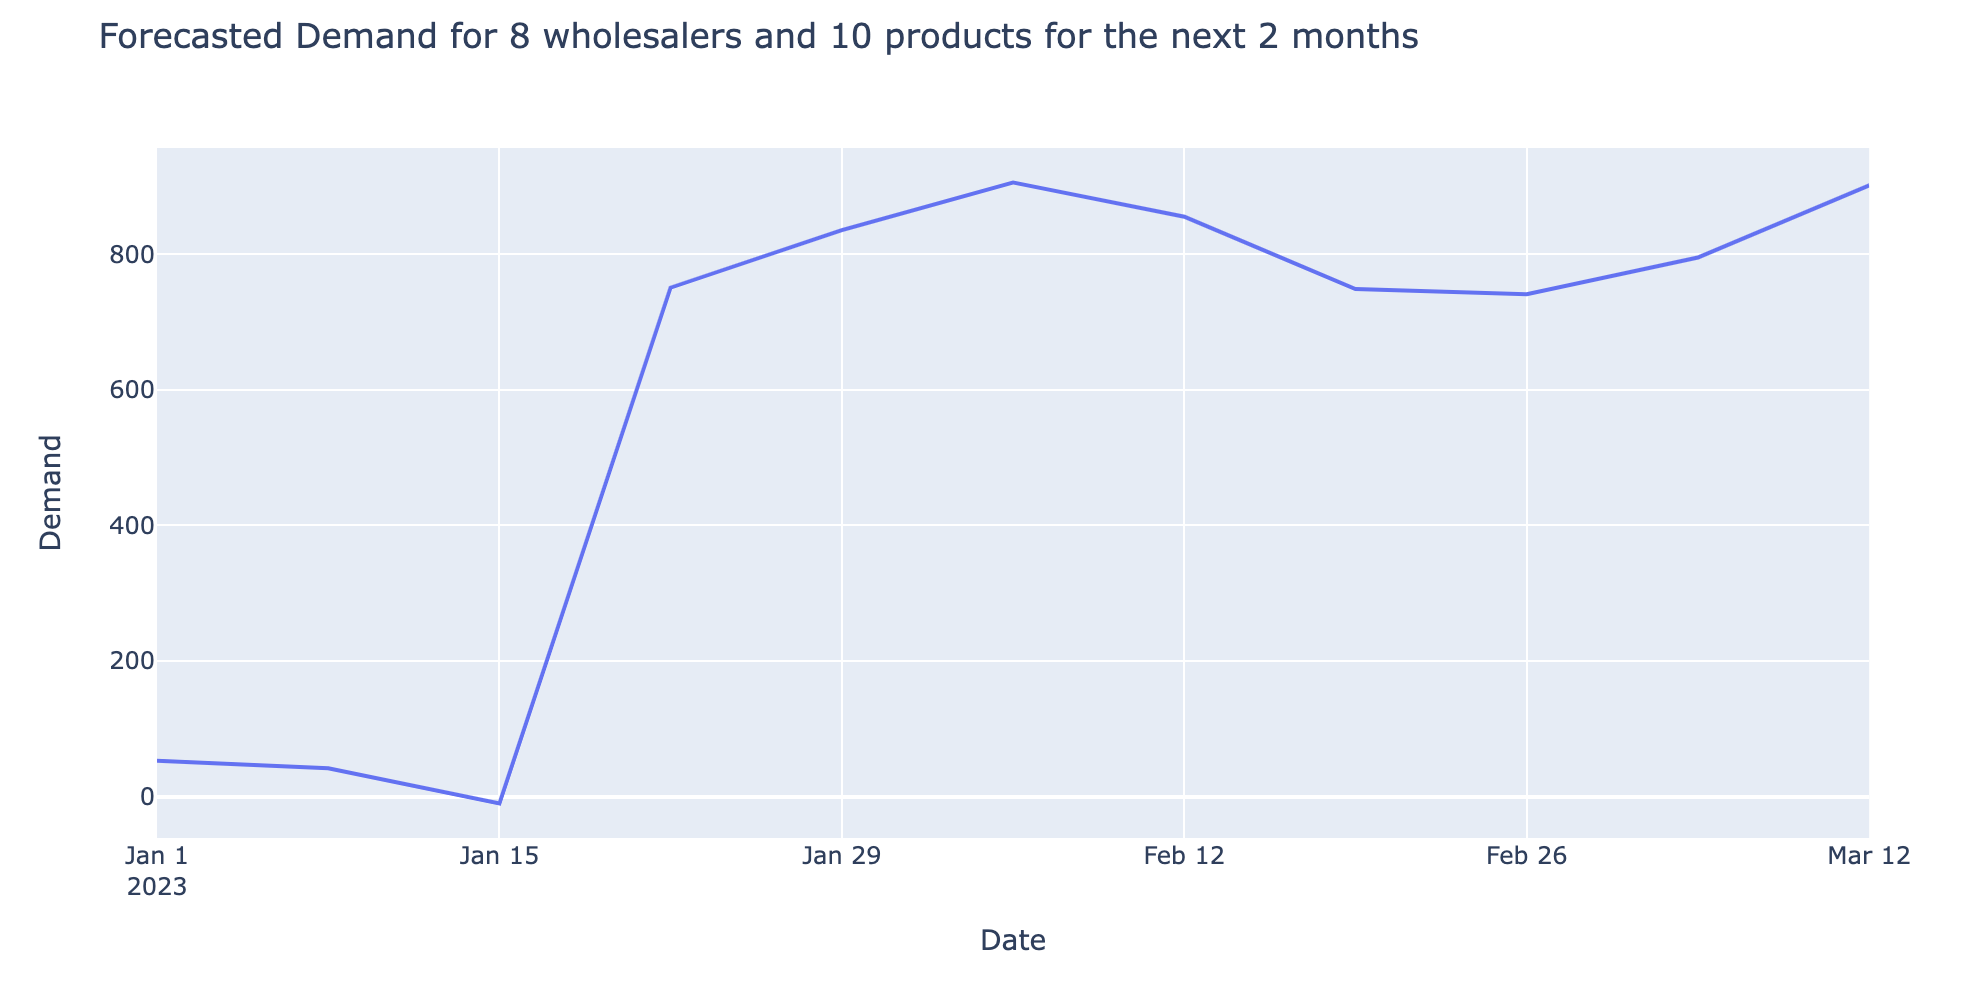

## Conclusion

**The forecasted values for the next 2 months in the future overall seems to also follow a similar trend that we had observed during EDA across years on average that demand starts to jump in early january and relatively stays consistent. Hence, it feels like the models did a decent job learning from the patterns and signals in the data.**
